# **Sales Analysis - Soi Bien retail datasets sales.csv**

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

## **Data Ingestion**

*Read* data into python from file sales.*csv* (read_csv)


In [4]:
df = pd.read_csv('/content/sales.csv')

##**Data Inspection & Preparation**

Define missing data

In [5]:
## (isna + sum)
nan_stats = df.isna().sum()/len(df)

For attributes with missing data rate > 80% => Delete that attribute (df.drop)

In [6]:
cols_to_drop = nan_stats[nan_stats > 0.8].index.to_list()
df.drop(columns = cols_to_drop, inplace = True)

For attributes with missing data rate < 1% => Delete rows with missing data in that attribute (df.dropna combined with subset)


In [7]:
features_important = nan_stats[nan_stats < 0.01].index.to_list()
df.dropna(subset = features_important, inplace=True)

Create an additional created_date attribute that represents the invoice date through the created_at attribute

In [8]:
def get_created_date(created_at_str):
    return created_at_str[:10]

In [9]:
df['created_date'] = df.created_at.map(get_created_date)


## **Data Analysis**

### Revenue Analysis

Determine the **Total Revenue** of the whole chain by day

In [10]:
df.groupby('created_date').agg({'amount': sum})

,amount
created_date,
2018-04-01,1063518.25
2018-04-02,1890504.25
2018-04-03,1696963.95
2018-04-04,2207518.00
2018-04-05,2215943.25
...,...
2019-02-02,3656300.75
2019-02-03,4030351.00
2019-02-04,197315.00


Determine **Total Revenue**, **Number of Orders**, **Average Revenue per order** by each goods category (`goods_category`)

In [46]:
stats_by_goods_category_df = df.groupby('goods_category').agg({'amount': sum, 'order_code': 'nunique'}).reset_index()
stats_by_goods_category_df.rename(columns={'amount':'total_amount', 'order_code': 'n_order_code'}, inplace = True)
stats_by_goods_category_df['avg'] = stats_by_goods_category_df['total_amount']/stats_by_goods_category_df['n_order_code']

The product category in the data is a very detailed category (for example: `Product group\INSTANT FOOD\FRUITS AND VEGETABLE PRODUCTS`).
We need to extract the analysis for the parent categories (i.e. `INSTANT FOODS`).
**Next, we perform analysis on total revenue, number of orders, average revenue per order of parent categoriess on a daily basis.**

In [14]:
df.goods_category[0]

'Nhóm hàng\\THỰC PHẨM ĂN LIỀN\\SẢN PHẨM TỪ RAU CỦ QUẢ'

In [15]:
def get_goods_parent_category(goods_category):
    return goods_category.split('\\')[1]

In [16]:
df['goods_parent_category'] = df.goods_category.map(get_goods_parent_category)

In [17]:
stats_by_goods_parent_category_df = df.groupby('goods_parent_category').agg({'amount': sum, 'order_code': 'nunique'}).reset_index()
stats_by_goods_parent_category_df.rename(columns={'amount':'total_amount', 'order_code': 'n_order_code'}, inplace = True)
stats_by_goods_parent_category_df['avg'] = stats_by_goods_category_df['total_amount']/stats_by_goods_category_df['n_order_code']

In [19]:
stats_by_goods_parent_category_df

,goods_parent_category,total_amount,n_order_code,avg
0,RAU CỦ,5.914922e+08,31462,22215.016058
1,THỰC PHẨM ĂN LIỀN,1.848440e+08,10102,16623.584946


### Customer Analysis

Determine the **Total Revenue per customer** throughout the whole chain




In [20]:
### (groupby customer_id)
stats_customer_df = df.groupby('customer_id').agg({'amount': sum}).reset_index()

In [21]:
stats_customer_df.rename(columns={'amount': 'total_amount'}, inplace = True)

### VIP customer analysis
- Definition of a VIP customer: having a total amount of money spent on the system > 5 million VND.
- From the DataFrame to determine the total amount of money per customer above, add an `is_vip` column to that DataFrame according to the condition:
If total consumption > 5 million => True, otherwise it is False









In [22]:
def is_vip(value):
    return value > 5e6

In [23]:
stats_customer_df['is_vip'] = stats_customer_df.total_amount.map(is_vip)

In [24]:
stats_customer_df

,customer_id,total_amount,is_vip
0,0000114,44800.0,False
1,0001,19200.0,False
2,01253688259,16000.0,False
3,01645432336,12800.0,False
4,01665288569,19840.0,False
...,...,...,...
11632,ƯERWERWADR,51150.0,False
11633,ƯETGWE,82225.0,False
11634,ƯEWEWE,9600.0,False
11635,ẢLHGOPOPJK,15500.0,False


In [25]:
## merge dataframe with original dataframe
new_df = pd.merge(df, stats_customer_df, left_on='customer_id', right_on='customer_id', how ='left')

Only consider orders from VIP customers, filter the resulting dataframe above to only retain rows with the attribute `is_vip` as True.

In [26]:
new_df = new_df[new_df.is_vip == True]

Determine the total spending of VIP customers by day

In [27]:
stats_vip_cus_df = new_df.groupby('customer_id').agg({'amount': sum})

In [28]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

Determine the last time the data was recorded

In [29]:
input_date_str = df.created_at.max()

In [30]:
input_date = datetime.strptime(input_date_str, '%Y-%m-%d %H:%M:%S')
# Calculate 6 months before the input date
six_months_ago = input_date - relativedelta(months=6)

In [31]:
six_months_ago

datetime.datetime(2018, 8, 13, 15, 25, 53)

### Churn Analysis

Definition: A churning customer is a customer whose last purchase was at least 6 months before the last time of data recording. For example, the last time to record data is July 1, 2019, churning customers are customers whose last order was before January 1, 2019.
Return the DataFrame containing these customers (information includes: customer id, customer name and phone number)

In [32]:
stats_churn_df = df.groupby(['customer_id', 'customer', 'customer_phone_number']).agg({'created_at': max}).reset_index()

In [33]:
stats_churn_df['created_at'] = pd.to_datetime(stats_churn_df['created_at'])

In [34]:
stats_churn_df['is_churn'] = stats_churn_df['created_at'] < six_months_ago

In [35]:
len(stats_churn_df[stats_churn_df.is_churn == True])

2843

### Some Data Visualizations

In [36]:
revenue_by_goods = df.groupby("goods_name").agg({"amount":sum})
revenue_by_goods

,amount
goods_name,
Rau gia vị VietGap,8.112183e+07
Rau hữu cơ,2.438764e+08
Rau quả VietGap,2.664940e+08
Đậu mơ,1.848440e+08


#### *Revenue by Goods Name*

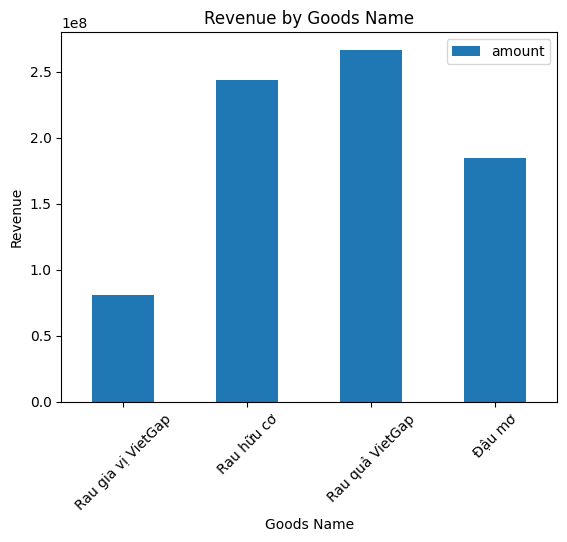

In [42]:
revenue_by_goods.plot(kind = 'bar')
plt.xlabel("Goods Name")
plt.ylabel("Revenue")
plt.title("Revenue by Goods Name")
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
# plt.savefig('./imgs/bar_chart_2.png', bbox_inches='tight')
plt.show()

#### *Revenue by Goods Name and Branch*

In [43]:
## Convert dataframe into appropriate format for grouped bar chart
revenue_by_goods_branch = df.pivot_table(values = 'amount', index='branch',columns='goods_name', aggfunc=sum)

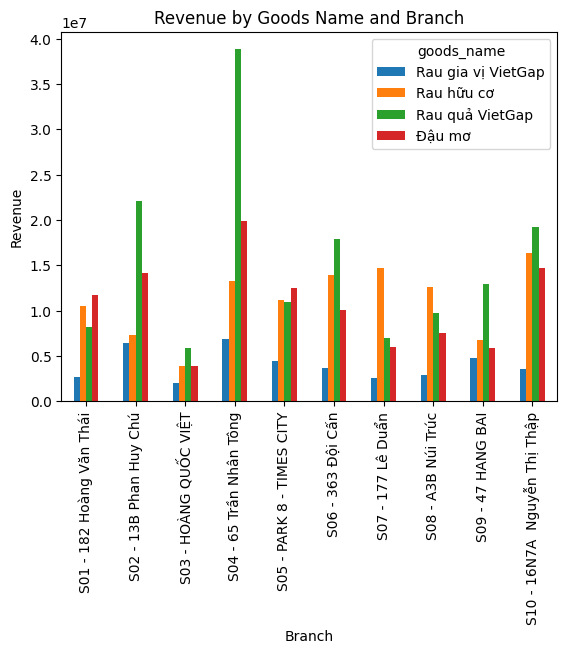

In [44]:
revenue_by_goods_branch[:10].plot(kind='bar')
plt.ylabel("Revenue")
plt.xlabel("Branch")
plt.title("Revenue by Goods Name and Branch")
plt.show()

#### *Revenue by Date*

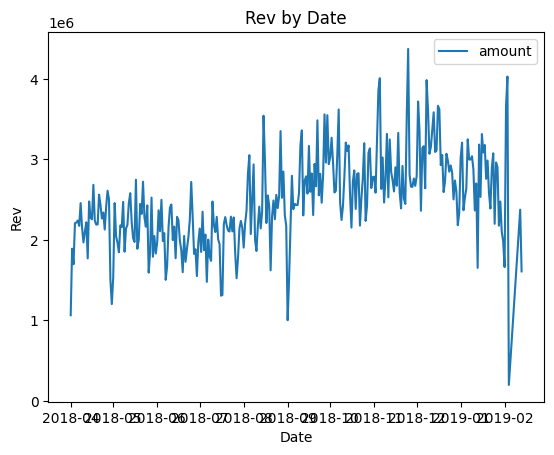

In [45]:
df['created_date'] = pd.to_datetime(df.created_at).dt.date
rev_by_date_df = df.groupby('created_date').agg({'amount': sum})
rev_by_date_df.plot(kind = 'line')
plt.xlabel('Date')
plt.ylabel('Rev')
plt.title('Rev by Date')
plt.show()

#### *Revenue by Goods Name and Month*

In [47]:
def get_month(created_at):
    return created_at[:7]

In [48]:
df.dropna(subset=['created_at'], inplace = True)

In [49]:
df['created_month'] = df.created_at.map(get_month)

In [50]:
df['created_month'] = df.created_at.astype('str').map(lambda x: x[:7])

In [51]:
monthly_revenue_by_goods = df.pivot_table(values = 'amount', index='created_month',columns='goods_name', aggfunc=sum)

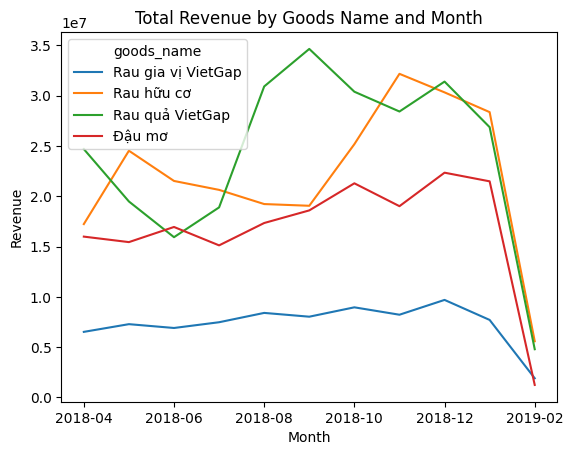

In [53]:
monthly_revenue_by_goods.plot(kind = 'line')
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.title("Total Revenue by Goods Name and Month")
plt.show()

#### *Number of Orders by Month*

In [54]:
# Count number of orders by Month
norder_by_month_df = df.groupby('created_month').agg({'order_code': 'nunique'})

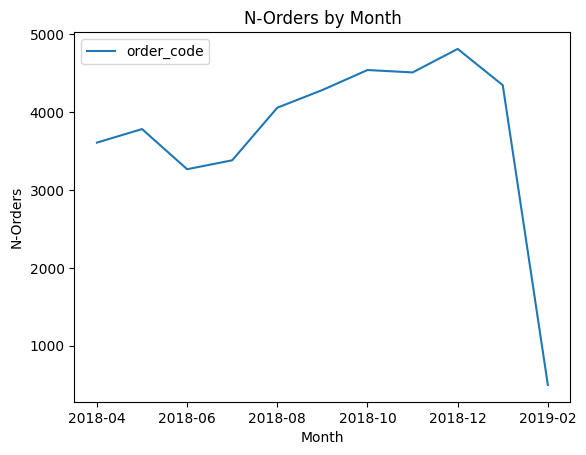

In [55]:
# Plotting
norder_by_month_df.plot(kind='line')
plt.xlabel('Month')
plt.ylabel('N-Orders')
plt.title('N-Orders by Month')
plt.show()

#### *Revenue Proportion by Branch*

<Axes: ylabel='amount'>

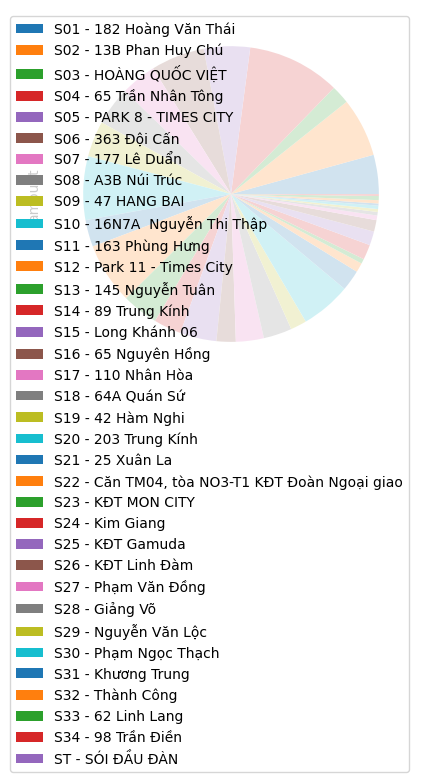

In [56]:
rev_by_branch_df = df.groupby('branch').agg({'amount':sum})
rev_by_branch_df.plot(kind ='pie', y ='amount', labels = None)

#### *Customer Traffic by Hour*

<Axes: ylabel='Frequency'>

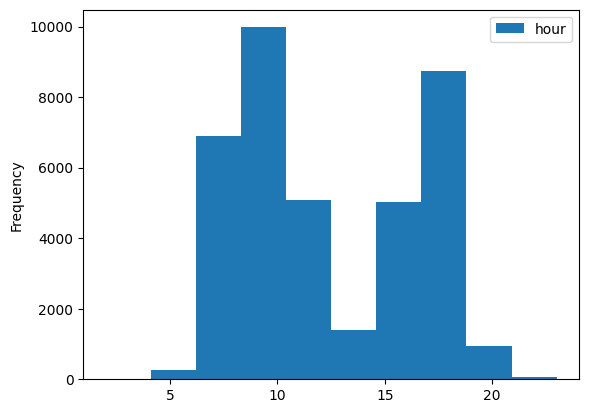

In [57]:
df['hour'] = pd.to_datetime(df.created_at).dt.hour
df.drop_duplicates(subset=['customer_id', 'created_date', 'hour'], inplace = True)
df.plot(kind='hist', y='hour')